# 1. Imports

In [1]:
import cv2
import tensorflow as tf
import os
import numpy as np
import logging
import imageio
from IPython.display import Image, display
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import vidaug.augmentors as va
from sklearn.model_selection import StratifiedKFold
import time
import itertools
from io import BytesIO
import pandas as pd

# Suppress TensorFlow warnings
tf.get_logger().setLevel(logging.ERROR)

# Show all columns in pandas
pd.set_option('display.max_rows', None)

# 2. Global Variables and Constants

In [2]:
NUM_FRAMES = 16  # Default number of frames (used in data preprocessing)
FRAME_SIZE = (224, 224)  # Width, height
BATCH_SIZE = 16  # Default batch size
RES_DIR = os.path.join('..', 'res')
CLASSES = ['squat', 'deadlift', 'bench press']
NUM_CLASSES = len(CLASSES)
TRAIN_SIZE = 0.7
VALIDATION_SIZE = 0.15
CHECKPOINT_FILEPATH = 'model.keras'
SHOW_VISUALIZATIONS = True  # Avoid visualizations
TEST = False  # Avoid time consuming operations
FIGURES_DIR = os.path.join(RES_DIR, 'figs')  # Folder containing figures created by the script

In [3]:
os.makedirs(FIGURES_DIR, exist_ok=True)  # Create figures directory if it does not exist

# 3. Helper Functions

In [4]:
def extract_frames(video_path, num_frames=NUM_FRAMES, frame_size=FRAME_SIZE, rescale=True):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Calculate frame indices to sample
    frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)

    frames = []
    for frame_idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)

        ret, frame = cap.read()
        if not ret:
            break

        # Convert to color, resize and normalize frame
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, frame_size)

        if rescale:
            frame = frame / 255.0
            
        frames.append(frame)

    cap.release()

    # Padding if necessary
    if len(frames) < num_frames:
        frames.extend([frames[-1]] * (num_frames - len(frames)))

    frames = np.array(frames)

    if frames.ndim != 4:
        frames = np.expand_dims(frames, axis=-1)  # Add channel dimension

    return frames

In [5]:
def to_gif(images, filename=None):
    if images.shape[-1] == 1:
        images = images.squeeze(-1)
        
    converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
    
    buffer = BytesIO()
    imageio.mimsave(buffer, converted_images, format='GIF', fps=10, loop=0)
    buffer.seek(0)
    
    if filename:
        with open(os.path.join(FIGURES_DIR, filename), 'wb') as f:
            f.write(buffer.getvalue())
    
    # Display the GIF
    return display(Image(data=buffer.read(), format='png'))

In [6]:
def results_to_dataframe(results):
    # Extract data
    df = pd.DataFrame(
        {
            "num_frames": [int(key.split(":")[-1].strip("} ")) for key in results.keys()],
            "accuracy": [value["accuracy"] for value in results.values()],
            "loss": [value["loss"] for value in results.values()],
            "elapsed_time": [value["elapsed_time"] for value in results.values()]
        }
    )
    
    return df

In [7]:
def add_channel_dim(images: np.ndarray):
    if images.ndim == 4:
        return images
    
    return np.expand_dims(images, axis=-1)

# 4. Data Preparation

## 4.1. Frame Extraction and Preprocessing

In [8]:
def get_paths_and_labels(video_dir, labels):
    video_paths = []
    video_labels = []

    for idx, label in enumerate(labels):
        class_dir = os.path.join(video_dir, label)
        for video in os.listdir(class_dir):
            video_path = os.path.join(class_dir, video)

            video_paths.append(video_path)
            video_labels.append(idx)
    
    return video_paths, video_labels

In [9]:
paths, labels = get_paths_and_labels(RES_DIR, CLASSES)

In [10]:
print(f"Number of videos: {len(paths)}")

Number of videos: 121


## 4.2. Data Splitting

In [11]:
X_temp, X_test, y_temp, y_test = train_test_split(paths, labels, test_size=(1 - TRAIN_SIZE - VALIDATION_SIZE), stratify=labels, random_state=42)

# 5. Exploratory Data Analysis (EDA)

## 5.1. Frame Visualization

In [12]:
def visualize_frames(video_paths, video_labels, num_samples=1, filename=None):
    # Select random indices
    indices = np.random.choice(len(video_paths), num_samples, replace=False)
    
    for idx in indices:
        video = extract_frames(video_paths[idx])
        label = CLASSES[video_labels[idx]]
        
        # Select a random frame from the video
        frame_idx = np.random.randint(0, video.shape[0])
        frame = video[frame_idx]
        print(f"Shape of frame: {frame.shape}")
        
        plt.figure(figsize=(5, 5))
        plt.imshow(frame)
        plt.title(f"Label: {label.title()}. Frame: {frame_idx + 1}")
        plt.axis('off')
        
        if filename:
            plt.savefig(os.path.join(FIGURES_DIR, f"{filename}_{idx}.png"), dpi=300)

        plt.show()
        plt.clf()
        plt.close()

Shape of frame: (224, 224, 3)


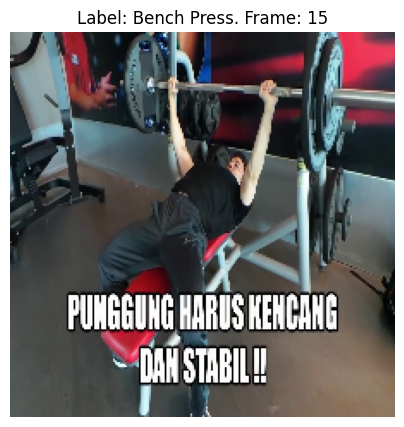

In [13]:
if SHOW_VISUALIZATIONS:
    visualize_frames(X_temp, y_temp, 1)

## 5.2. Temporal Analysis

In [14]:
def visualize_temporal_sequence(X, y, num_samples=1, frames_to_show=None, filename=None):
    # Select random indices
    indices = np.random.choice(len(X), num_samples, replace=False)
    
    for idx in indices:
        video = extract_frames(X[idx])
        label = CLASSES[y[idx]]

        if frames_to_show is None:
            frames_to_show = video.shape[0]  # Should be NUM_FRAMES

        # Calculate number of rows based on frames_to_show and number of columns
        cols = 4
        rows = (frames_to_show + cols - 1) // cols

        # Show frames in grid
        plt.figure(figsize=(cols*3, rows*3))
        for i in range(frames_to_show):
            plt.subplot(rows, cols, i+1)
            plt.imshow(video[i])
            plt.axis('off')
            plt.title(f"Frame {i+1}")
        
        plt.suptitle(f"Video Label: {label}", fontsize=16)
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)

        if filename:
            plt.savefig(os.path.join(FIGURES_DIR, f"{filename}_{idx}.png"), dpi=300)

        plt.show()
        plt.clf()
        plt.close()

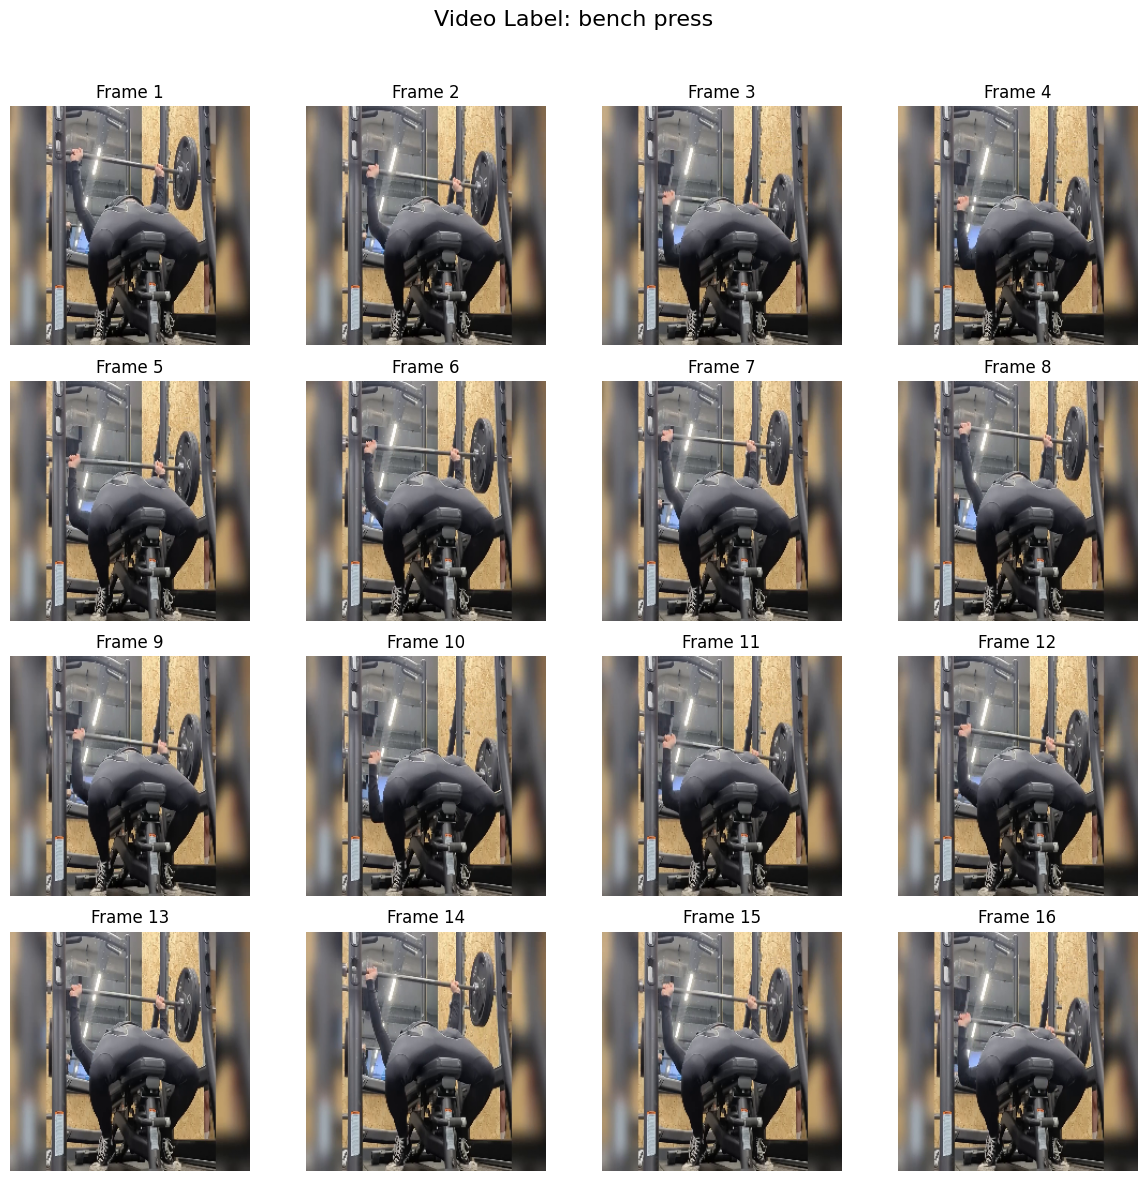

In [15]:
if SHOW_VISUALIZATIONS:
    visualize_temporal_sequence(X_temp, y_temp, num_samples=1, filename='temporal_sequence')

## 5.3. Class Distribution

In [16]:
def visualize_class_distribution(y, filename=None):
    # Count the occurrences of each class using numpy
    unique, counts = np.unique(y, return_counts=True)
    
    # Plot
    plt.figure(figsize=(8, 6))
    ax = sns.barplot(x=unique, y=counts)
    plt.title("Class Distribution")
    
    plt.xticks(ticks=np.arange(len(CLASSES)), labels=CLASSES, rotation=45)
    
    plt.xlabel('Class')
    plt.ylabel('Count')
    
    # Annotate each bar
    for i, count in enumerate(counts):
        ax.text(i, count + 1, str(count), ha='center', va='bottom', fontsize=10)

    if filename:
        plt.savefig(os.path.join(FIGURES_DIR, filename), dpi=300)

    plt.show()
    plt.clf()
    plt.close()

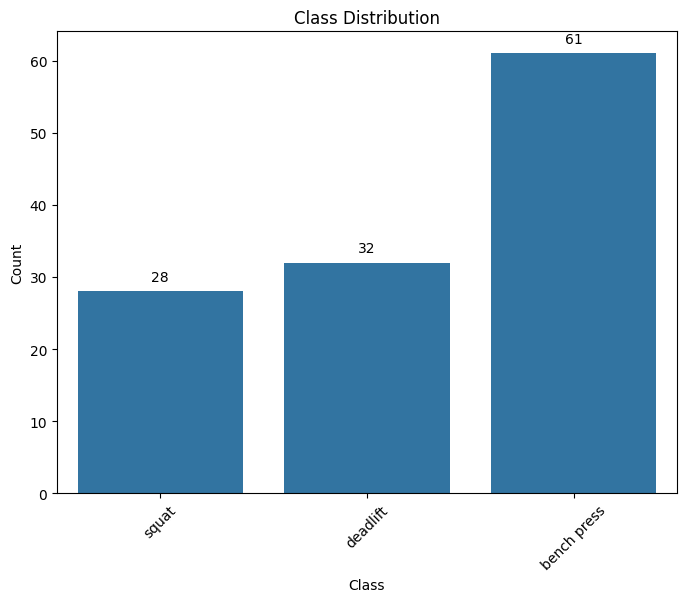

In [17]:
if SHOW_VISUALIZATIONS:
    visualize_class_distribution(labels, filename='class_distribution.png')

# 6. Feature Engineering

## 6.1. Motion Features

In [18]:
idx = np.random.randint(0, len(X_temp) - 1)  # Index as a sample

### 6.1.1. Frame differencing

In [19]:
def extract_frame_difference(video_path, threshold=30, assign_value=255):
    # https://medium.com/@abbessafa1998/motion-detection-techniques-with-code-on-opencv-18ed2c1acfa
    video = extract_frames(video_path, rescale=False)

    num_frames = video.shape[0]
    motion_masks = []

    # Convert all frames to grayscale
    gray_frames = [cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY) for frame in video]

    for t in range(1, num_frames):
        # Compute absolute difference between frames (t-1) and t
        diff = cv2.absdiff(gray_frames[t - 1], gray_frames[t])
        
        # Apply threshold to compute motion mask
        _, motion_mask = cv2.threshold(diff, threshold, assign_value, cv2.THRESH_BINARY)

        motion_mask = motion_mask / 255.0
        motion_masks.append(motion_mask)

    if len(motion_masks) < NUM_FRAMES:
        motion_masks.extend([motion_masks[-1]] * (NUM_FRAMES - len(motion_masks)))

    motion_masks = np.array(motion_masks)
    return add_channel_dim(motion_masks)

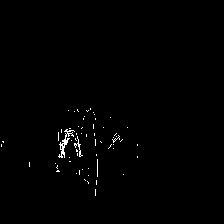

In [20]:
if SHOW_VISUALIZATIONS:
    to_gif(extract_frame_difference(X_temp[idx]), filename='frame_difference_example.gif')

### 6.1.2. Background Subtraction

In [21]:
def extract_background_subtraction(video_path, threshold=30, assign_value=255):
    video = extract_frames(video_path, rescale=False)

    num_frames = video.shape[0]
    motion_masks = []

    # Convert all frames to grayscale
    gray_frames = [cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY) for frame in video]

    # Initialize the background with the first frame
    background = gray_frames[0]

    for t in range(1, num_frames):
        # Compute the absolute difference between the background and current frame
        diff = cv2.absdiff(background, gray_frames[t])

        # Apply thresholding to create a motion mask
        _, motion_mask = cv2.threshold(diff, threshold, assign_value, cv2.THRESH_BINARY)

        # Normalize motion mask to [0, 1] for consistency
        motion_mask = motion_mask / 255.0
        motion_masks.append(motion_mask)

    if len(motion_masks) < NUM_FRAMES:
        motion_masks.extend([motion_masks[-1]] * (NUM_FRAMES - len(motion_masks)))

    motion_masks = np.array(motion_masks)
    return add_channel_dim(motion_masks)

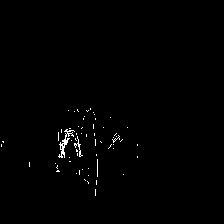

In [22]:
if SHOW_VISUALIZATIONS:
    to_gif(extract_background_subtraction(X_temp[idx]), filename='background_subtraction_example.gif')

### 6.1.3. Adaptive Background Substraction

In [23]:
def extract_adaptive_background_subtraction(video_path, threshold=30, assign_value=255, alpha=0.5):
    video = extract_frames(video_path, rescale=False)

    num_frames = video.shape[0]
    motion_masks = []

    # Convert all frames to grayscale
    gray_frames = [cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) for frame in video[:num_frames]]

    # Initialize the background with the first frame
    background = gray_frames[0]

    for t in range(1, num_frames):
        # Compute the absolute difference between the background and current frame
        diff = cv2.absdiff(background.astype(np.uint8), gray_frames[t])

        # Apply thresholding to create a motion mask
        _, motion_mask = cv2.threshold(diff, threshold, assign_value, cv2.THRESH_BINARY)

        # Update the background using the adaptive approach
        background = alpha * gray_frames[t] + (1 - alpha) * background

        # Normalize motion mask to [0, 1] for consistency
        motion_mask = motion_mask / 255.0
        motion_masks.append(motion_mask)

    if len(motion_masks) < NUM_FRAMES:
        motion_masks.extend([motion_masks[-1]] * (NUM_FRAMES - len(motion_masks)))

    motion_masks = np.array(motion_masks)
    return add_channel_dim(motion_masks)

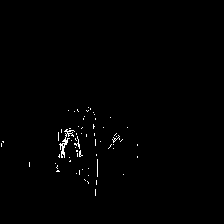

In [24]:
if SHOW_VISUALIZATIONS:
    to_gif(extract_adaptive_background_subtraction(X_temp[idx]), filename='adaptive_background_subtraction_example.gif')

### 6.1.4. Mixture of Gaussians (MoG)

In [25]:
def extract_mog(video_path, learning_rate=-1):
    video = extract_frames(video_path, rescale=False)
    
    num_frames = video.shape[0]
    fgbg = cv2.createBackgroundSubtractorMOG2()
    motion_masks = []

    for t in range(num_frames):
        # Apply MOG to compute motion mask
        motion_mask = fgbg.apply(video[t], learningRate=learning_rate)

        motion_mask = motion_mask / 255.0
        motion_masks.append(motion_mask)

    motion_masks = np.array(motion_masks)
    return add_channel_dim(motion_masks)

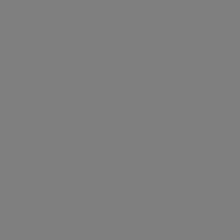

In [26]:
if SHOW_VISUALIZATIONS:
    to_gif(extract_mog(X_temp[idx]), filename='mog_example.gif')

## 6.2. Data Augmentation

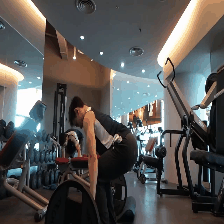

In [27]:
if SHOW_VISUALIZATIONS:
    frames_1 = extract_frames(X_temp[idx])
    to_gif(frames_1, filename='original_example.gif')

In [28]:
class VideoRandomFlip(tf.keras.layers.Layer):
    def __init__(self, mode="horizontal", **kwargs):
        super().__init__(**kwargs)
        self.mode = mode

    def call(self, inputs: tf.Tensor, training=None, force=False):
        if not training:  # No augmentation during inference
            return inputs

        # Determine flip axes based on the mode
        flip_horizontal = self.mode in ["horizontal", "horizontal_and_vertical"]
        flip_vertical = self.mode in ["vertical", "horizontal_and_vertical"]

        # Function to apply flip on each frame
        def apply_flip_to_frame(frame, flip_h, flip_v):
            if flip_h:
                frame = tf.image.flip_left_right(frame)
            if flip_v:
                frame = tf.image.flip_up_down(frame)
            return frame
        
        def apply_flip_to_video(video):
            flip_h = tf.random.uniform((), minval=0, maxval=1) > 0.5 or force if flip_horizontal else False
            flip_v = tf.random.uniform((), minval=0, maxval=1) > 0.5 or force if flip_vertical else False
            return tf.map_fn(lambda frame: apply_flip_to_frame(frame, flip_h, flip_v), video)

        if inputs.shape.rank == 4:  # Single video (T, H, W, C)
            return apply_flip_to_video(inputs)

        if inputs.shape.rank == 5:  # Batch of videos (N, T, H, W, C)
            return tf.map_fn(lambda video: apply_flip_to_video(video), (inputs))

        raise ValueError(
            "Expected video inputs to have rank 4 (T, H, W, C) or 5 (N, T, H, W, C). "
            f"Got shape: {inputs.shape}."
        )

In [29]:
class VideoResize(tf.keras.layers.Layer):
    def __init__(self, size, interpolation="bilinear", **kwargs):
        super().__init__(**kwargs)
        self.size = size
        self.interpolation = interpolation

    def call(self, inputs: tf.Tensor, training=None):
        def apply_resize_to_frame(frame):
            return tf.image.resize(frame, self.size, method=self.interpolation)
        
        def apply_resize_to_video(video):
            return tf.map_fn(apply_resize_to_frame, video)
        
        if inputs.shape.rank == 4:  # Single video (T, H, W, C)
            return apply_resize_to_video(inputs)
        
        if inputs.shape.rank == 5:  # Batch of videos (N, T, H, W, C)
            return tf.map_fn(lambda video: apply_resize_to_video(video), inputs)
        
        raise ValueError(
            "Expected video inputs to have rank 4 (T, H, W, C) or 5 (N, T, H, W, C). "
            f"Got shape: {inputs.shape}."
        )

In [30]:
class VideoRandomCenterCrop(tf.keras.layers.Layer):
    def __init__(self, height_factor, width_factor, keep_dims=False, **kwargs):
        super().__init__(**kwargs)
        self.height_factor = height_factor
        self.width_factor = width_factor
        self.resize = VideoResize((FRAME_SIZE[0], FRAME_SIZE[1])) if keep_dims else None

    def call(self, inputs: tf.Tensor, training=None):
        if not training:  # No augmentation during inference
            return inputs
        
        # Height and width of input videos
        height = tf.cast(tf.shape(inputs)[-3], tf.float32)
        width = tf.cast(tf.shape(inputs)[-2], tf.float32)

        def apply_crop_to_frame(frame, offset_height, offset_width, target_height, target_width):
            return tf.image.crop_to_bounding_box(frame, offset_height, offset_width, target_height, target_width)
        
        def apply_crop_to_video(video):
            # Randomly choose crop size factors within the provided ranges
            height_factor = tf.random.uniform((), minval=self.height_factor[0], maxval=self.height_factor[1])
            width_factor = tf.random.uniform((), minval=self.width_factor[0], maxval=self.width_factor[1])

            # Compute the top-left corner for the crop (first computes pixels to lose)
            top = tf.cast((height * height_factor) / 2, tf.int32)
            left = tf.cast((width * width_factor) / 2, tf.int32)

            # Compute the new size of the video after cropping
            target_height = (tf.cast(height, tf.int32) - top * 2)
            target_width = (tf.cast(width, tf.int32) - left * 2)

            # Apply cropping to all frames in the video
            augmented_video = tf.map_fn(lambda frame: apply_crop_to_frame(frame, top, left, target_height, target_width), video)

            # Resize if needed
            if self.resize:
                augmented_video = self.resize(augmented_video)

            return augmented_video

        if inputs.shape.rank == 4:  # Single video (T, H, W, C)
            return apply_crop_to_video(inputs)

        if inputs.shape.rank == 5:  # Batch of videos (N, T, H, W, C)
            return tf.map_fn(lambda video: apply_crop_to_video(video), inputs)

        raise ValueError(
            "Expected video inputs to have rank 4 (T, H, W, C) or 5 (N, T, H, W, C). "
            f"Got shape: {inputs.shape}."
        )

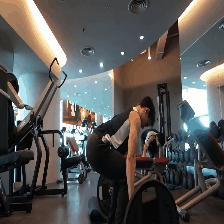

In [31]:
if SHOW_VISUALIZATIONS:
    flip_augmentor = VideoRandomFlip(mode="horizontal")
    # resize_augmentor = VideoResize(size=FRAME_SIZE)
    # crop_augmentor = VideoRandomCenterCrop(height_factor=(0, 0.2), width_factor=(0, 0.2), keep_dims=True)
    augmented_videos = flip_augmentor(tf.convert_to_tensor(frames_1), training=True, force=True)

    # Single testing
    to_gif(augmented_videos.numpy(), filename='flip_example.gif')

    # Batch testing
    # to_gif(augmented_videos.numpy()[0])
    # to_gif(augmented_videos.numpy()[1])

# 7. The Model

## 7.1. Model design

In [32]:
def create_model(num_frames):
    # Load a pretrained model
    base_model = tf.keras.applications.InceptionV3(
        weights='imagenet',  # Load weights
        include_top=False,
        input_shape=(FRAME_SIZE[0], FRAME_SIZE[1], 3)
    )

    # Freeze the net layers
    base_model.trainable = False

    data_augmentation = tf.keras.Sequential([
        VideoRandomFlip(mode="horizontal"),
        # VideoRandomCenterCrop(height_factor=(0, 0.2), width_factor=(0, 0.2), keep_dims=True)
    ], name="data_augmentation")

    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(num_frames, FRAME_SIZE[0], FRAME_SIZE[1], 3)),

        # Apply data augmentation
        data_augmentation,

        # Process each frame through the pretrained model
        tf.keras.layers.TimeDistributed(base_model),

        # Reduce dimensionality
        tf.keras.layers.TimeDistributed(tf.keras.layers.GlobalAveragePooling2D()),

        # GRU for temporal learning
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=False)),

        # Fully connected layers for classification
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu'),

        # Output layer
        tf.keras.layers.Dense(NUM_CLASSES)
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                  metrics=['accuracy'])

    return model

In [33]:
model = create_model(NUM_FRAMES)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequenti  (None, 16, 224, 224, 3)  0         
 al)                                                             
                                                                 
 time_distributed (TimeDistr  (None, 16, 5, 5, 2048)   21802784  
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 16, 2048)         0         
 tributed)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 16, 256)          1672704   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              2

In [34]:
del model

## 7.2. Dataset design

In [35]:
def data_generator(paths, targets, func, params):
    for path, target in zip(paths, targets):
        frames = func(path, **params)
        yield frames, target

In [36]:
def create_dataset(paths, targets, func: callable, params: dict):
    return tf.data.Dataset.from_generator(
        lambda: data_generator(paths, targets, func, params), 
        output_signature=(
            tf.TensorSpec(shape=(params.get('num_frames', NUM_FRAMES), FRAME_SIZE[0], FRAME_SIZE[1], 3), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.int32)
        )
    )

In [37]:
AUTOTUNE = tf.data.AUTOTUNE

def prepare(dataset: tf.data.Dataset, shuffle=False):
  dataset = dataset.cache()

  if shuffle:
    dataset = dataset.shuffle(1000)

  dataset = dataset.batch(BATCH_SIZE)

  return dataset.prefetch(buffer_size=AUTOTUNE)

# 8. Evaluating extraction parameters

In [38]:
def run_model(X_train, y_train, X_val, y_val, func, params, return_history, verbose):
    # Start timing
    start_time = time.perf_counter()

    # Create datasets for training and validation
    train_ds = create_dataset(X_train, y_train, func=func, params=params)
    val_ds = create_dataset(X_val, y_val, func=func, params=params)

    # Prepare the datasets
    train_ds = prepare(train_ds, shuffle=True)
    val_ds = prepare(val_ds)

    # Create the model
    model = create_model(params.get('num_frames', NUM_FRAMES))

    # Learning rate scheduler and early stopping
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)
    # early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)  # Reduce the risk of overfitting

    # Train the model
    history = model.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[reduce_lr], verbose=verbose)

    if return_history:
        return history

    # Evaluate the model on validation data
    loss, accuracy = model.evaluate(val_ds, verbose=0)

    # Calculate elapsed time
    elapsed_time = time.perf_counter() - start_time

    return loss, accuracy, elapsed_time

In [39]:
def test_extraction_method_with_params(X_temp, y_temp, func, parameters=None, k=3):
    # Generate all possible parameter combinations using itertools.product
    param_combinations = list(itertools.product(*parameters.values())) if parameters else [()]

    print('------------------------------------------------------------------------')
    print(f"Testing frame extraction method: {func.__name__}. K: {k}")

    # Store results
    results = {}

    # Loop through each parameter combination
    for param_set in param_combinations:
        # Create a dictionary of parameters for the current combination
        param_dict = dict(zip(parameters.keys(), param_set)) if parameters else {}

        print(f"Testing parameters: {param_dict}")

        accuracies = []
        losses = []
        times = []

        if k is None:  # For quick testing
            X_train, X_val, y_train, y_val = train_test_split(
                X_temp, y_temp,
                train_size=TRAIN_SIZE / (TRAIN_SIZE + VALIDATION_SIZE),
                stratify=y_temp,
                random_state=42
            )

            # Run the model with the current parameters
            result = run_model(X_train, y_train, X_val, y_val, func, param_dict, return_history=False, verbose=0)

            loss, accuracy, time_taken = result

            accuracies.append(accuracy * 100)
            losses.append(loss)
            times.append(time_taken)
        else:
            skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
            fold_no = 1

            # Stratified K-Fold Cross-Validation
            for train_index, val_index in skf.split(X_temp, y_temp):
                # Split paths and labels into training and validation sets
                X_train, X_val = np.array(X_temp)[train_index], np.array(X_temp)[val_index]
                y_train, y_val = np.array(y_temp)[train_index], np.array(y_temp)[val_index]

                # Run the model with the current parameters
                result = run_model(X_train, y_train, X_val, y_val, func, param_dict, return_history=False, verbose=0)

                loss, accuracy, time_taken = result

                accuracies.append(accuracy * 100)
                losses.append(loss)
                times.append(time_taken)
                fold_no += 1

        avg_accuracy = np.mean(accuracies)
        avg_loss = np.mean(losses)
        total_time = np.sum(times)

        # Store results
        results[str(param_dict)] = {
            "accuracy": avg_accuracy,
            "loss": avg_loss,
            "elapsed_time": total_time
        }

    return results

## 8.1. Performance with Extract Frames

In [40]:
if TEST:
    k = 3  # Number of folds for cross-validation

    parameters = {
        'num_frames': [2, 4, 8, 16, 32],
    }

    extract_frames_results = test_extraction_method_with_params(
        X_temp=X_temp,
        y_temp=y_temp,
        func=extract_frames,
        parameters=parameters,
        k=k
    )

In [41]:
if TEST and extract_frames_results:
    results_df = results_to_dataframe(extract_frames_results)
    results_df.head()

For all experiment the number of splits is 3

(No augmentation)

|	|num_frames|	accuracy|	loss|	elapsed_time|
|------|------|------|------|------|
|0|	2|	89.215686|	0.372267|	235.787914|
|1|	4|	91.176470|	0.353208|	269.676073|
|2|	8|	90.196079|	0.410411|	450.984143|
|3|	16|	91.176468|	0.372010|	1033.471241|
|4|	32|	90.196077|	0.415564|	1869.285406|

(Only random horizontal flip)

||	num_frames|	accuracy|	loss|	elapsed_time|
|------|------|------|------|------|
|0|	2|	89.215684|	0.362144|	297.589557|
|1|	4|	94.117645|	0.238260|	386.174774|
|2|	8|	90.196079|	0.361921|	693.035556|
|3|	16|	89.215686|	0.333939|	1157.514449|
|4|	32|	88.235293|	0.377601|	1985.717385|

(Only random center crop)

||num_frames|	accuracy	|loss	|elapsed_time|
|------|------|------|------|------|
|0|	2|	90.196077|	0.307025|	315.981754|
|1|	4|	87.254902|	0.347564	|417.386800|
|2|	8|	87.254902|	0.436362|	1133.121224|
|3|	16|	89.215686|	0.325290|	1492.774826|
|4|	32|	90.196079|	0.316628|	2629.287430|

(Random center crop and random horizontal flip)

||	num_frames|	accuracy|	loss|	elapsed_time|
|------|------|------|------|------|
|0|	2|	91.176470|	0.307600|	324.237976|
|1|	4|	87.254900|	0.360304|	446.240952|
|2|	8|	90.196077|	0.316336|	706.525661|
|3|	16|	86.274509|	0.389331|	1252.138003|
|4|	32|	88.235293|	0.505120|	2581.715898|

# 9. Model Training

In [42]:
BATCH_SIZE = 32
NUM_FRAMES = 8

In [43]:
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    train_size=TRAIN_SIZE / (TRAIN_SIZE + VALIDATION_SIZE),
    stratify=y_temp,
    random_state=42
)

train_ds = create_dataset(X_train, y_train, func=extract_frames, params={'num_frames': NUM_FRAMES})
val_ds = create_dataset(X_val, y_val, func=extract_frames, params={'num_frames': NUM_FRAMES})
test_ds = create_dataset(X_test, y_test, func=extract_frames, params={'num_frames': NUM_FRAMES})

# Prepare the datasets
train_ds = prepare(train_ds, shuffle=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

In [44]:
model = create_model(num_frames=NUM_FRAMES)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)  # Reduce the risk of overfitting

history = model.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[reduce_lr, early_stopping], verbose=1)

Epoch 1/100
3/3 [==============================] - 54s 6s/step - loss: 1.1746 - accuracy: 0.2738 - val_loss: 1.0008 - val_accuracy: 0.4444 - lr: 1.0000e-04
Epoch 2/100
3/3 [==============================] - 1s 504ms/step - loss: 1.0904 - accuracy: 0.3929 - val_loss: 0.9521 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 3/100
3/3 [==============================] - 1s 503ms/step - loss: 0.9432 - accuracy: 0.5000 - val_loss: 0.9072 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 4/100
3/3 [==============================] - 1s 510ms/step - loss: 0.8554 - accuracy: 0.6548 - val_loss: 0.8616 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 5/100
3/3 [==============================] - 1s 495ms/step - loss: 0.8409 - accuracy: 0.5833 - val_loss: 0.8201 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 6/100
3/3 [==============================] - 1s 509ms/step - loss: 0.8665 - accuracy: 0.6310 - val_loss: 0.7760 - val_accuracy: 0.6667 - lr: 1.0000e-04
Epoch 7/100
3/3 [==============================] - 1s 

In [45]:
def plot_train_vs_val_metric(history, metric, title, filename=None):
    train_metric = metric
    val_metric = f"val_{metric}"
    
    metric_array_1 = history.history[train_metric]
    metric_array_2 = history.history[val_metric]

    plt.plot(metric_array_1, label=f"Training {metric}")
    plt.plot(metric_array_2, label=f"Validation {metric}")

    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(metric.title())

    plt.legend()

    if filename:
        plt.savefig(os.path.join(FIGURES_DIR, filename), dpi=300)
    plt.show()
    plt.clf()
    plt.close()

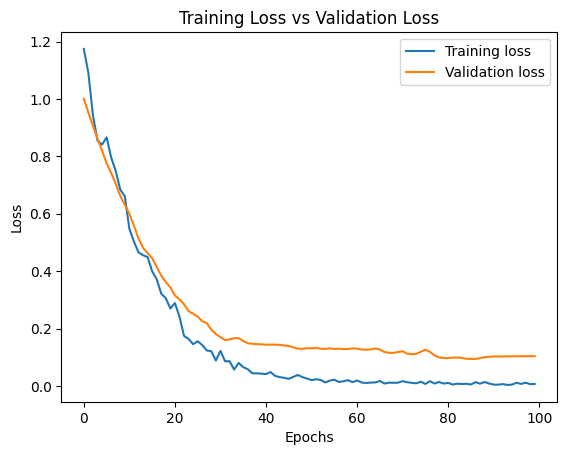

In [46]:
if SHOW_VISUALIZATIONS:
    plot_train_vs_val_metric(history, 'loss', 'Training Loss vs Validation Loss', filename='training_loss_vs_validation_loss.png')

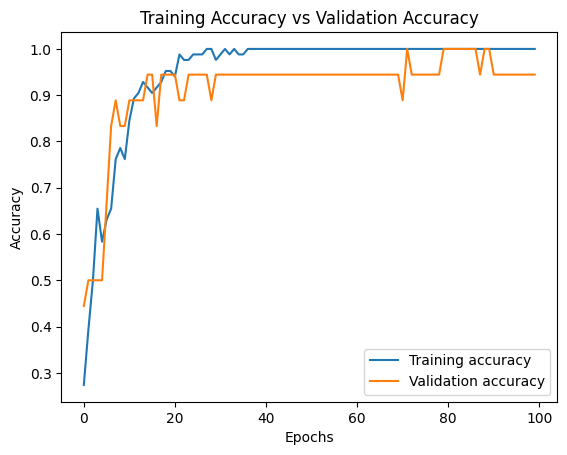

In [47]:
if SHOW_VISUALIZATIONS:
    plot_train_vs_val_metric(history, 'accuracy', 'Training Accuracy vs Validation Accuracy', filename='training_accuracy_vs_validation_accuracy.png')

In [48]:
y_true = []
y_pred = []

for frames, labels in val_ds:
    predictions = model.predict(frames)
    predicted_classes = np.argmax(predictions, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_classes)

1/1 [==============================] - 3s 3s/step


In [49]:
y_true = np.array(y_true).flatten()
y_pred = np.array(y_pred)

In [50]:
def plot_confusion_matrix(y_true, y_pred, classes, title, filename=None):
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)

    plt.title(title)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')

    if filename:
        plt.savefig(os.path.join(FIGURES_DIR, filename), dpi=300)
        
    plt.show()
    plt.clf()
    plt.close()

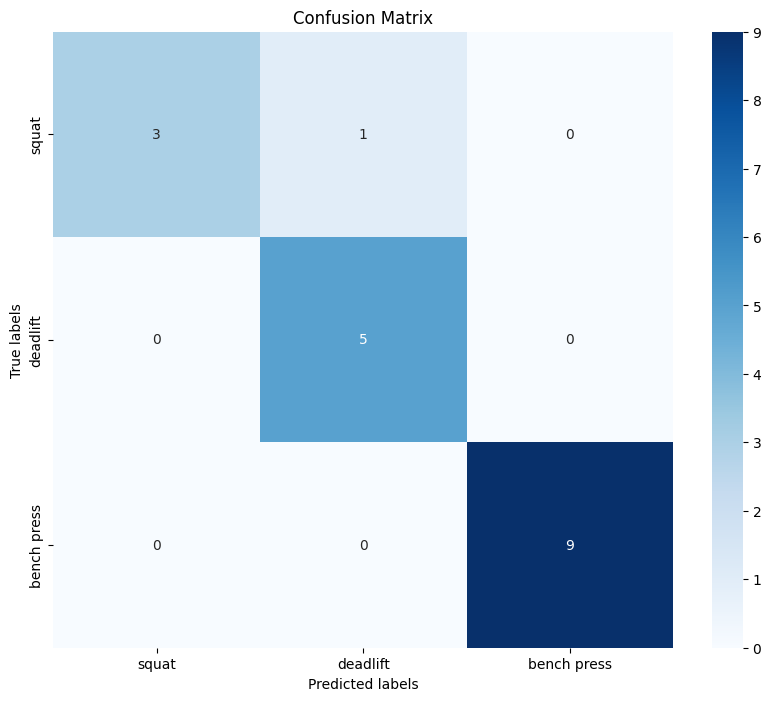

In [51]:
if SHOW_VISUALIZATIONS:
    plot_confusion_matrix(y_true, y_pred, CLASSES, 'Confusion Matrix', filename='confusion_matrix.png')

In [52]:
def display_misclassified_videos(model, dataset):
    num_misclassified = 0
    for batch, (videos, labels) in enumerate(dataset):
        # Get predictions for the batch
        predictions = model.predict(videos, verbose=0)
        predicted_classes = np.argmax(predictions, axis=1)
        
        true_classes = labels.numpy()
        
        # Identify misclassified samples
        for i in range(len(videos)):
            if predicted_classes[i] != true_classes[i]:
                print(f"True Class: {CLASSES[true_classes[i]]}, Predicted Class: {CLASSES[predicted_classes[i]]}")
                
                frames = videos[i].numpy()
                
                # Generate GIF from video frames
                print("Displaying incorrectly classified video...")
                to_gif(frames)

                num_misclassified += 1

    if num_misclassified == 0:
        print("No videos were misclassified!")

True Class: squat, Predicted Class: deadlift
Displaying incorrectly classified video...


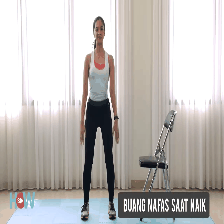

In [53]:
if SHOW_VISUALIZATIONS:
    display_misclassified_videos(model, val_ds)

# 10. Model Testing

In [54]:
print(f"Number of train cases: {len(X_train)}")
print(f"Number of validation cases: {len(X_val)}")
print(f"Number of test cases: {len(X_test)}")

Number of train cases: 84
Number of validation cases: 18
Number of test cases: 19


In [55]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

1/1 [==============================] - 6s 6s/step - loss: 0.0599 - accuracy: 1.0000
Test Accuracy: 100.00%


## 10.1. Save the model weights

In [56]:
model.save_weights(CHECKPOINT_FILEPATH)

In [57]:
del model